In [2]:
import cv2 as cv
import numpy as np

In [3]:
avg_kernel = np.ones((3,3), dtype=np.float32)
avg_kernel /= 9
avg_kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

In [4]:
from Datasets import Datasets

In [10]:
ac_dataset = Datasets.datasets()["AcMüDüHo"]
train = ac_dataset[0].images

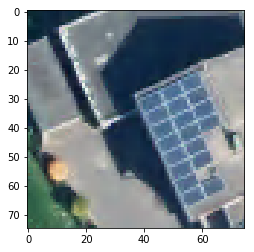

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train[1][:,:,::-1])

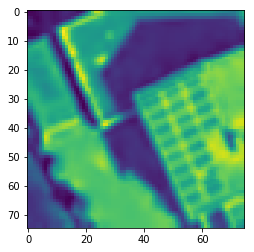

In [22]:
orig = train[1]
dest = cv.filter2D(orig, -1, avg_kernel)
plt.imshow(dest[:,:,0])

In [23]:
orig.shape, dest.shape

((75, 75, 3), (75, 75, 3))

In [70]:
def window_locations(r=2):
    x = [-r, 0, r]
    y = [-r, 0, r]
    mask = np.zeros((3+r,3+r))
    
    for xc in x:
        for yc in y:
            mask[r + yc, r + xc] = 1.0
    return np.tile(mask,(3,1,1)).T
    
window_mask = window_locations()
window_mask

array([[[1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]]])

In [49]:
a = np.array([[1,2,3,4,5],
             [6,7,8,9,10],
             [11,12,13,14,15],
             [16,17,18,19,20],
             [21,22,23,24,25]])
a * window_mask

array([[ 1.,  0.,  3.,  0.,  5.],
       [ 0.,  0.,  0.,  0.,  0.],
       [11.,  0., 13.,  0., 15.],
       [ 0.,  0.,  0.,  0.,  0.],
       [21.,  0., 23.,  0., 25.]])

In [73]:
def extract_features(image):
    #grab the spatial dimensions of the image, along with
    # the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    
    kernel = window_locations()
    (kH, kW) = kernel.shape[:2]

    # allocate memory for the output image, taking care to
    # "pad" the borders of the input image so the spatial
    # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv.copyMakeBorder(image, pad, pad, pad, pad,
        cv.BORDER_REPLICATE)
    output = np.zeros((iH, iW, 27), dtype="float32")
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top to
    # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

            # perform the actual selection by taking the
            # element-wise multiplicate between the ROI and
            # the kernel
            k = (roi * kernel)

            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad, :] = k[np.nonzero(kernel)]
    
    # return the output image
    return output

In [76]:
output = extract_features(dest)
output.shape

(75, 75, 27)